In [169]:
import numpy as np
import pandas as pd
import seaborn as sns
from selfregulation.utils.utils import get_behav_data
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.model_selection import KFold, cross_val_predict, cross_val_score
from sklearn.pipeline import make_pipeline
from fancyimpute import SoftImpute


### Define Helper functions


In [166]:
# using for speed, for the time being
def SoftImpute_df(data):
    imputed_mat = SoftImpute(verbose=False).complete(data)
    return pd.DataFrame(data=imputed_mat, columns=data.columns, index=data.index)

def data_reduce(data, n_components, method=FactorAnalysis):
    fa=method(n_components)
    # Impute (replace with missForest later)
    imputed_subset = SoftImpute_df(subset)
    # Scale data
    scaler = StandardScaler()
    scaled_subset = scaler.fit_transform(imputed_subset)
    # fit model on subset
    transformed_subset = fa.fit_transform(scaled_subset)
    return transformed_subset 

def run_FA(n_components,data,cv):
    fa=FactorAnalysis(n_components)
    scores = []
    # cross-validate fit across different train/test splits
    for train_index, test_index in cv.split(data.values):
        data_train, data_test = data.iloc[train_index], \
                                data.iloc[test_index]
        # Impute (replace with missForest later)
        imputed_train = SoftImpute_df(data_train)
        imputed_test = SoftImpute_df(data_test)
        # Scale data
        scaler = StandardScaler()
        scaled_train = scaler.fit_transform(imputed_train)
        scaled_test = scaler.transform(imputed_test)
        # fit model on training
        fa.fit(scaled_train)
        # score on test set
        scores.append(fa.score(scaled_test))
    #average score across kfolds
    score = np.mean(scores)
    return score, fa

def find_optimal_components(data, method='sklearn', cv=None):
    if method == 'sklearn':
        assert cv, "Must Supply a CV if using sklearn"
        # find best number of components
        n_components = range(1,12)
        best_c = 0
        component_scores = []
        for c in n_components:
            score, fa = run_FA(c,data,cv)
            component_scores.append(score)
        best_c = np.argmax(component_scores)+1
        print('Best Component: ', best_c)
        return best_c, component_scores
    elif method == 'psych':
        BICs = []
        outputs = []
        n_components = range(1,12)
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(data)
        for c in n_components:
            fa, output = psychFA(scaled_data, c, method='ml')
            BICs.append(output['BIC'])
            outputs.append(output)
        best_c = np.argmin(BICs)+1
        print('Best Component: ', best_c)
        return best_c, BICs

### Load Data

In [30]:
datafile = 'Complete_01-16-2017'
data = get_behav_data(dataset=datafile, file = 'taskdata_clean.csv')


Getting datasets...:
 /home/ian/Experiments/expfactory/Self_Regulation_Ontology/Data/Complete_01-16-2017


****************************************
Leaving out task: ravens
FA Accuracy: 0.56 (+/- 0.12)
PCA Accuracy: 0.51 (+/- 0.12)


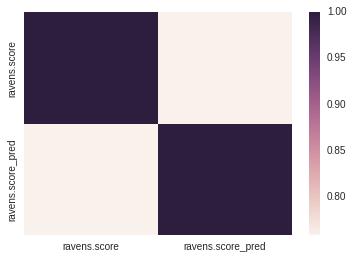

In [176]:
def out_of_task_prediction(data, task=None,n_components=None,verbose=True):
    if task is None:
        tasks = np.unique([i.split('.')[0] for i in data.columns])
        target_task = np.random.choice(tasks)
    else:
        target_task = task
    target = data.filter(regex = '^'+target_task+'\.')
    subset = data.drop(target.columns, axis=1)
    if n_components is None:
        # find optimal number of dimensions
        kf = KFold(n_splits = 4)
        n_components, component_scores = find_optimal_components(data,cv=kf)
    
    FA_transformed_subset = data_reduce(subset, n_components)
    PCA_transformed_subset = data_reduce(subset, n_components, method=PCA)
    # remove nans
    data_rows = target.notnull().all(1).nonzero()[0]
    target = target.iloc[data_rows,:]
    FA_transformed_subset = FA_transformed_subset[data_rows,:]
    PCA_transformed_subset = PCA_transformed_subset[data_rows,:]
    # predict left out task
    lr = LinearRegression()
    FA_scores = cross_val_score(lr, FA_transformed_subset, target, cv = 10)
    FA_score = FA_scores.mean()
    PCA_scores = cross_val_score(lr, PCA_transformed_subset, target, cv = 10)
    if verbose:
        print('*'*40)
        print('Leaving out task: %s' % target_task)
        print("FA Accuracy: %0.2f (+/- %0.2f)" % (FA_scores.mean(), FA_scores.std() * 2))
        print("PCA Accuracy: %0.2f (+/- %0.2f)" % (PCA_scores.mean(), FA_scores.std() * 2))
        
    predicted = cross_val_predict(lr, FA_transformed_subset, target, cv=10)
    predicted = pd.DataFrame(predicted,index=target.index,columns=[i+'_pred' for i in target.columns])
    df = pd.concat([target,predicted], axis=1)
    return df, FA_score

    
    
df, score = out_of_task_prediction(data ,n_components=11)
    
sns.heatmap(df.sort_index(axis=1).corr())